In [1]:
!pip install tensorflow

In [2]:
!pip install google-cloud-documentai

In [1]:
# feature extraction of images

import tensorflow as tf
import json
from io import BytesIO
import pandas as pd
from PIL import Image
from PIL import ImageFile
from keras.utils import load_img
from keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.python.platform import gfile

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

# other
# from google.colab import auth
from google.cloud import storage
import os
import matplotlib.pyplot as plt
import random
from random import randint
import pandas as pd
import pickle
import plotly.express as px
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.manifold import TSNE
import warnings
from google.cloud import documentai_v1beta3 as documentai
from mimetypes import guess_extension
from pathlib import Path
import gcsfs
from google.cloud import storage
from tqdm import tqdm_notebook

2023-04-25 08:55:24.948144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 08:55:29.076810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-25 08:55:29.076861: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-25 08:55:40.301433: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Convert Json to images

In [2]:
PROJECT_ID = "data-program-377222"
BUCKET_NAME = "zaid_bucket"
json_path = 'benchmarking_dataset/expense/eval/v1.0.0' #Add bucket name with path
IMAGES_PATH = "Template_cluster/test/expense/eval/eval_images" # remove bucket path

In [5]:


# bucket_name = "zaid_bucket"  
output_path = IMAGES_PATH
fs=gcsfs.GCSFileSystem(project=PROJECT_ID)
files=[i for i in fs.ls(json_path) if i.endswith(".json")]
def store_blob(document,file_name : str,contentType):
    """
    To store the file in cloud storage.
    """
    storage_client = storage.Client()
    process_result_bucket = storage_client.get_bucket(BUCKET_NAME)
    document_blob = storage.Blob(
        name=str(Path(output_path,file_name)),
        bucket=process_result_bucket)
    document_blob.upload_from_string(document, content_type=contentType)


def create_pdf_bytes(path):
    file_name = path.split("/")[-1].split(".")[0]
   
    x1=json.loads(fs.cat(path))
    if "docid" in x1.keys():
        del x1['docid']
    for entity in x1['entities']:
        if 'boundingPolyForDemoFrontend' in entity.keys():
            del entity['boundingPolyForDemoFrontend']
    for entity in x1['entities']:
        if 'properties' in entity.keys():
            for subentity in entity['properties']:
                if 'boundingPolyForDemoFrontend'in subentity.keys():
                    del subentity['boundingPolyForDemoFrontend']
                    
    d=documentai.Document
    document=d.from_json(json.dumps(x1))
    synthesized_images=[]
    for i in range(len(document.pages)):
        mime_type = document.pages[i].image.mime_type
        if not mime_type:
            mime_type = "image/png"
        file_name = file_name + "_"+str(i) + guess_extension(mime_type)
        store_blob(document.pages[i].image.content,file_name,mime_type)
        break
    # pdf_bytes=create_pdf_from_images(synthesized_images)

    return "done"
# file_done_count = 15588
# count = 0
for file in tqdm_notebook(files):
    # if count >= file_done_count:
    try:
        create_pdf_bytes(file)
    except Exception as e:
        print(f"Error on {file} >>",e)
    # count +=1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/268 [00:00<?, ?it/s]

# Create Cluster

In [6]:
# auth.authenticate_user()

# Instantiate a client and list files in the bucket that contains the images
storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.bucket(BUCKET_NAME)
blobs = storage_client.list_blobs(BUCKET_NAME, prefix=IMAGES_PATH)


In [7]:
def extract_features(blob, model):
    """
    loads and reshapes image file and then extracts feature vector
    :return: feature vector
    """
    # load the image as a 224x224 array
    img = load_img(BytesIO(blob.download_as_bytes()), target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

data = {}
count=0
# loop through each image in the dataset
for blob in tqdm_notebook(blobs):
    file_name = blob.name.split('/')[-1]
    
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(blob, model)
        data[file_name] = feat
    except:
        print(f"features were not extracted for {file_name}")
    count+=1

2023-04-18 07:29:04.307319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-18 07:29:04.307479: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-18 07:29:04.307547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (data-program-team): /proc/driver/nvidia/version does not exist
2023-04-18 07:29:04.308267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: Tq

0it [00:00, ?it/s]

1/1 [==============================] - 0s 306ms/step


In [9]:
# transform dictionary of features to np.array and reshape so that there are samples of 4096 features
feat = np.array(list(data.values()))
feat = feat.reshape(-1,4096)

# get a list of the filenames
filenames = np.array(list(data.keys()))

In [10]:
len(filenames)

268

In [11]:
# reduce the amount of dimensions to 200 using PCA
pca = PCA(n_components = 30, random_state = 10) #n_components is depends on 10% of the total_files and round of it.
# pca = PCA(n_components = 5, random_state = 10)
pca.fit(feat)
x = pca.transform(feat)
print(f"The shape of our data is {x.shape}")

The shape of our data is (268, 30)


413462.0  :  1
325134.25  :  2
275533.6875  :  3
243981.328125  :  4
228157.40625  :  5
215558.796875  :  6
203929.140625  :  7
196022.25  :  8
186925.40625  :  9
179034.6875  :  10
173847.1875  :  11
169853.84375  :  12
162792.546875  :  13
158938.046875  :  14
155880.078125  :  15
151159.671875  :  16
148614.375  :  17
142790.8125  :  18
140880.5625  :  19
139284.703125  :  20
133808.921875  :  21
131668.921875  :  22
128759.5078125  :  23
126506.2578125  :  24
124549.359375  :  25
121538.859375  :  26
118907.6171875  :  27
113022.65625  :  28
114825.4140625  :  29
108672.71875  :  30
109696.125  :  31
107481.078125  :  32
105656.984375  :  33
103321.4296875  :  34
100999.515625  :  35
100904.1328125  :  36
99248.8046875  :  37
95736.3515625  :  38
96341.2890625  :  39
93539.8359375  :  40
90882.484375  :  41
89260.5390625  :  42
87717.515625  :  43
86552.1640625  :  44
85434.2109375  :  45
84431.9296875  :  46
82581.140625  :  47
81652.3984375  :  48
81405.078125  :  49


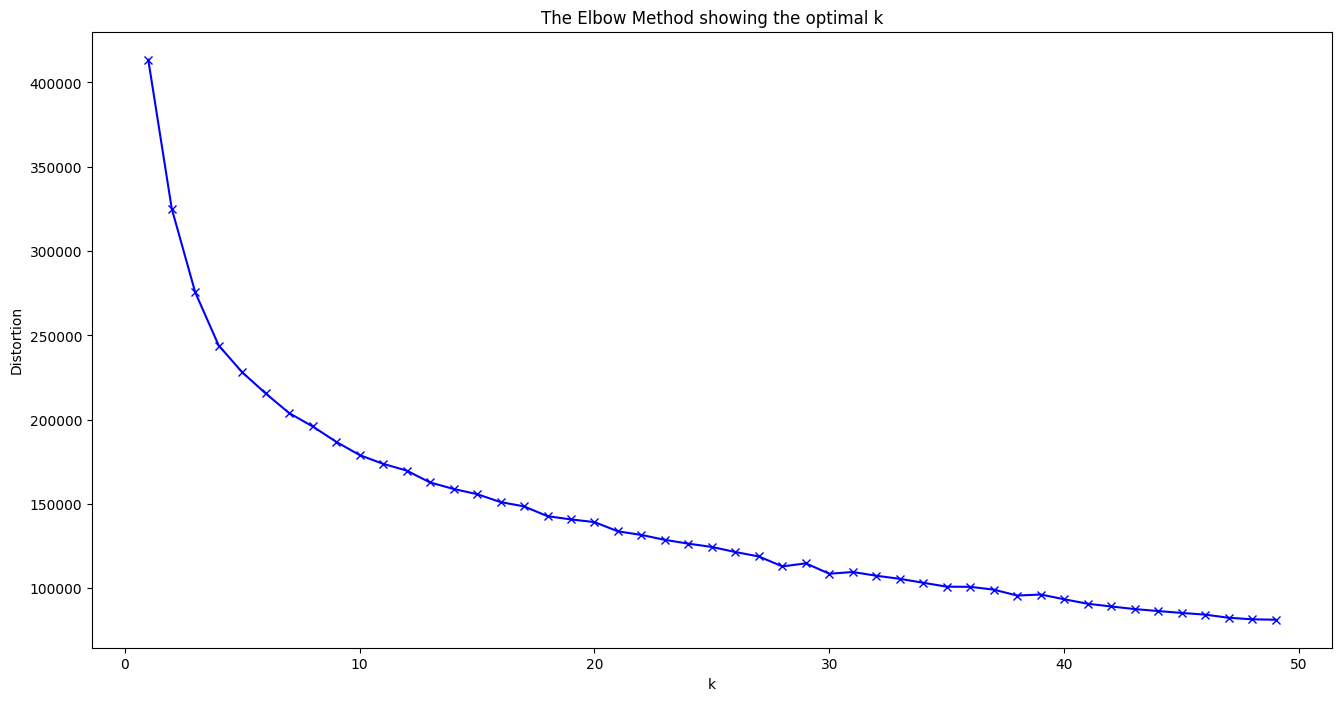

In [12]:
#evaluate number of clusters with Elbow Method
warnings.simplefilter(action='ignore', category=FutureWarning)

distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(x)
    distortions.append(kmeanModel.inertia_)
    print(kmeanModel.inertia_ , ' : ', k)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

413462.0  :  1
325134.25  :  2
275533.6875  :  3
243857.515625  :  4
228493.609375  :  5
215419.125  :  6
205203.6875  :  7
194473.5  :  8
186821.3125  :  9
180328.34375  :  10
171863.4375  :  11
168408.59375  :  12
162771.65625  :  13
159756.109375  :  14
156199.734375  :  15
152605.234375  :  16
148747.46875  :  17
143914.828125  :  18
141693.140625  :  19
137865.546875  :  20
135040.84375  :  21
131164.796875  :  22
130470.9375  :  23
124136.375  :  24
124422.6875  :  25
121697.34375  :  26
117332.4609375  :  27
116400.625  :  28
114927.8984375  :  29
112005.4375  :  30
108576.21875  :  31
106729.2734375  :  32
104205.15625  :  33
103953.5  :  34
101901.78125  :  35
98938.1171875  :  36
97708.359375  :  37
95508.875  :  38
94968.5859375  :  39
93169.328125  :  40
90891.2265625  :  41
89957.90625  :  42
89698.8125  :  43
86767.34375  :  44
85935.109375  :  45
84686.15625  :  46
81783.875  :  47
80614.171875  :  48
78532.796875  :  49


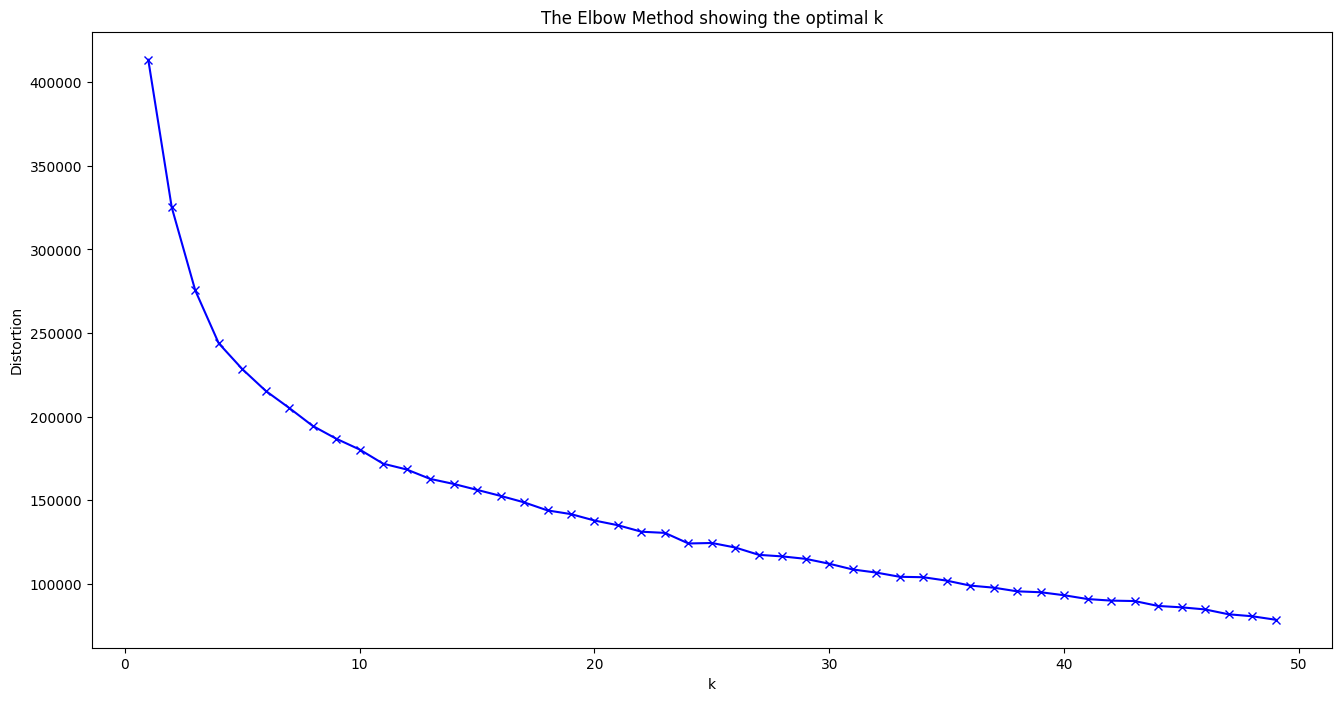

[88327.75, 49600.5625, 31676.171875, 15363.90625, 13074.484375, 10215.4375, 10730.1875, 7652.1875, 6492.96875, 8464.90625, 3454.84375, 5636.9375, 3015.546875, 3556.375, 3594.5, 3857.765625, 4832.640625, 2221.6875, 3827.59375, 2824.703125, 3876.046875, 693.859375, 6334.5625, -286.3125, 2725.34375, 4364.8828125, 931.8359375, 1472.7265625, 2922.4609375, 3429.21875, 1846.9453125, 2524.1171875, 251.65625, 2051.71875, 2963.6640625, 1229.7578125, 2199.484375, 540.2890625, 1799.2578125, 2278.1015625, 933.3203125, 259.09375, 2931.46875, 832.234375, 1248.953125, 2902.28125, 1169.703125, 2081.375]


In [13]:
#evaluate number of clusters with Elbow Method
warnings.simplefilter(action='ignore', category=FutureWarning)

distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(x)
    
    if k == 1:
        different_result = []
    else:
        different_result.append(a - kmeanModel.inertia_)
    
    a = kmeanModel.inertia_
    
    distortions.append(kmeanModel.inertia_)
    print(kmeanModel.inertia_ , ' : ', k)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

print(different_result)

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for i in range(2,50):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(x)

    # Calculate the silhouette score
    labels = kmeans.labels_

    silhouette_avg = silhouette_score(x, kmeans.labels_)
    print(f"The average silhouette score for K={i} is :{silhouette_avg}" )
    

The average silhouette score for K=2 is :0.19544202089309692
The average silhouette score for K=3 is :0.18686458468437195
The average silhouette score for K=4 is :0.18293428421020508
The average silhouette score for K=5 is :0.16624705493450165
The average silhouette score for K=6 is :0.15454481542110443
The average silhouette score for K=7 is :0.16404438018798828
The average silhouette score for K=8 is :0.1564195156097412
The average silhouette score for K=9 is :0.16337864100933075
The average silhouette score for K=10 is :0.1793786585330963
The average silhouette score for K=11 is :0.17480888962745667
The average silhouette score for K=12 is :0.17219415307044983
The average silhouette score for K=13 is :0.16802804172039032
The average silhouette score for K=14 is :0.17816920578479767
The average silhouette score for K=15 is :0.17405466735363007
The average silhouette score for K=16 is :0.1773025095462799
The average silhouette score for K=17 is :0.1789930760860443
The average silhouet

In [16]:
# cluster feature vectors into 6 clusters with kmeans algorithm
kmeans = KMeans(n_clusters=24,random_state=22)
kmeans.fit(x)
df = pd.DataFrame(columns = ['FileName',"cluster"])
# print(df)
# generate dictionary that holds the cluster id and the file names { id: [file_name] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    # print(file,cluster)
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
        dict = {'FileName':file,"cluster":cluster}
        df = df.append(dict,ignore_index=True)
    else:
        groups[cluster].append(file)
        dict = {'FileName':file,"cluster":cluster}
        df = df.append(dict,ignore_index=True)


In [17]:
pwd

'/home/jupyter'

In [18]:
cd image Cluster Results

/home/jupyter/image Cluster Results


In [19]:
pwd

'/home/jupyter/image Cluster Results'

In [20]:
df.to_csv('Expense/eval_output_18thApril.csv')
df2 = df.groupby("cluster").count()
df2.rename(columns = {"FileName" : 'File_Count'},inplace = True)
df2.to_csv('Expense/eval_group_output_18thApril.csv')

# Analysis

In [21]:
cluster_to_remove = list(df2[df2['File_Count'] < 5].index)
len(cluster_to_remove)

5

In [22]:
for i in cluster_to_remove:
    print(df[df['cluster'] == i]['FileName'])

168    Image5795136RK-2_0.png
Name: FileName, dtype: object
45      Image5719855RK-1_0.png
66     Image5731482RK-13_0.png
257     Image5815930RK-1_0.png
Name: FileName, dtype: object
84      Image5745283RK-1_0.png
144    Image5781784RK-25_0.png
145    Image5781784RK-27_0.png
252     Image5815239RK-3_0.png
Name: FileName, dtype: object
117     Image5773297RK-1_0.png
119     Image5773340RK-1_0.png
210    Image5808595RK-15_0.png
248     Image5814721RK-6_0.png
Name: FileName, dtype: object
102    Image5763116RK-1_0.png
Name: FileName, dtype: object


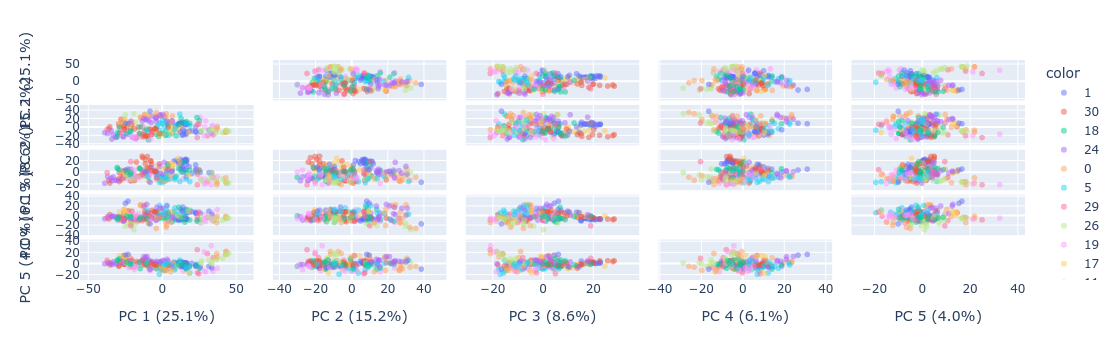

In [82]:
# Plot scatter matrix of first 5 PCA dimensions with cluster assignment
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

d = {'cluster_labels':  [str(g) for g in kmeans.labels_]}
kmeans_df = pd.DataFrame(data=d)

fig = px.scatter_matrix(
    x,
    labels=labels,
    dimensions=range(5),
    color=kmeans_df.cluster_labels,
    opacity=0.5
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [83]:
def view_cluster(groups_dict, cluster, n_images):
    """
    function to view a random sample of images of a cluster (based on identifier)
    """
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups_dict[cluster]
    if len(files) > n_images:
        print(f"Clipping cluster size from {len(files)} to {n_images}")
        files = random.sample(files, n_images)

    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        blob = bucket.blob(f"{IMAGES_PATH}/{file}")
        img = load_img(BytesIO(blob.download_as_bytes()), target_size=(224,224))
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



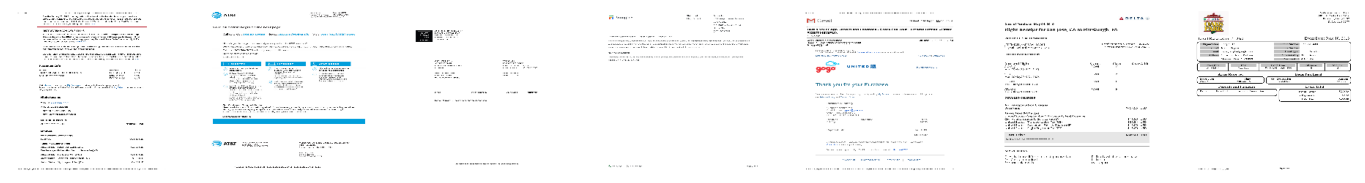

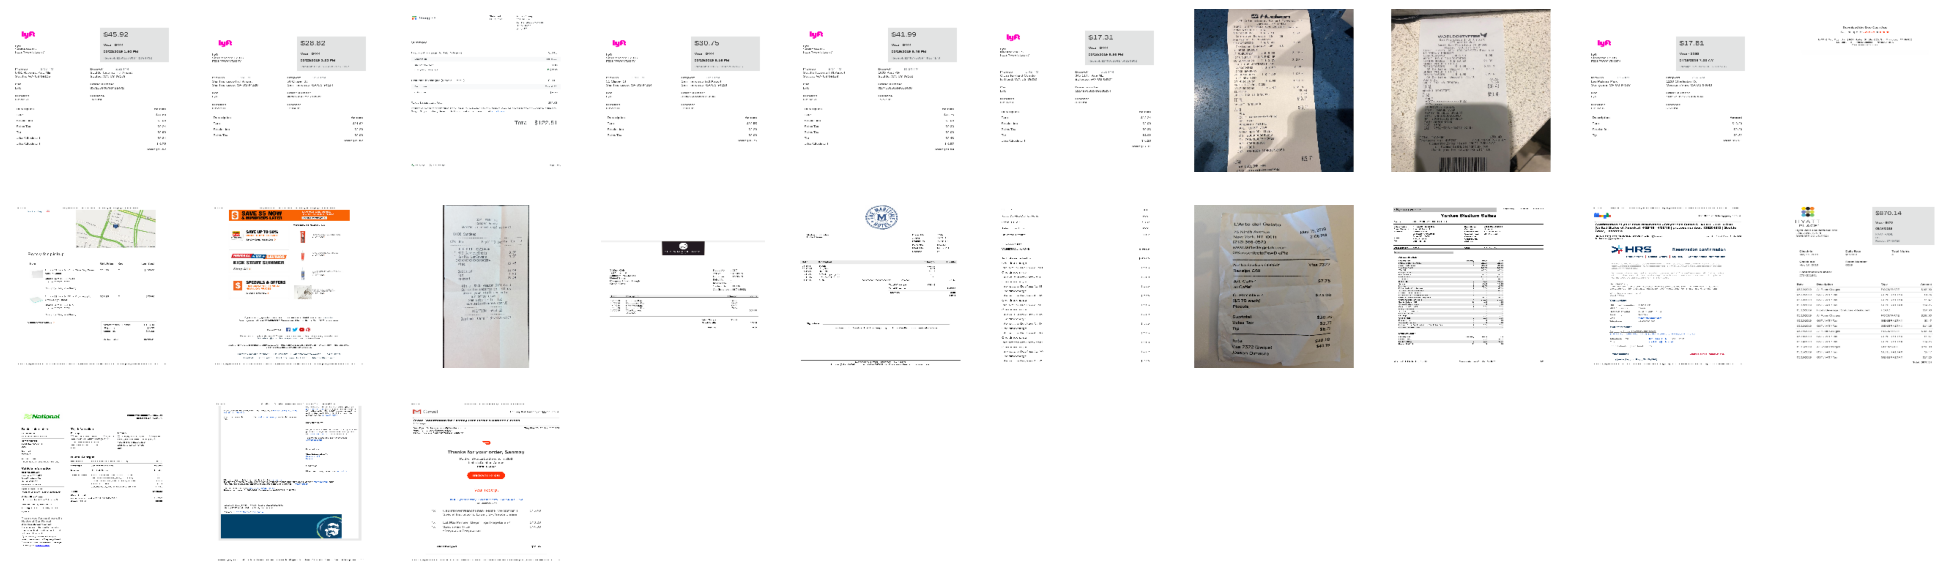

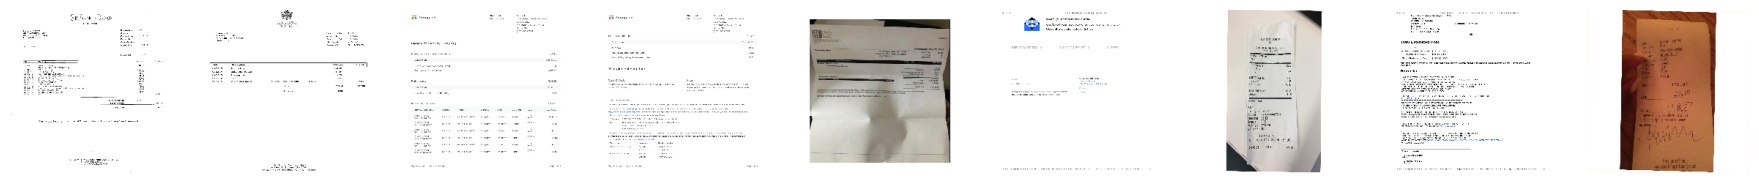

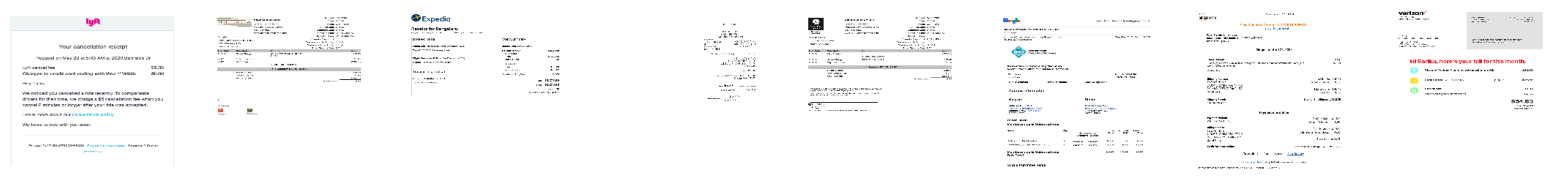

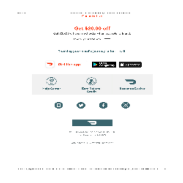

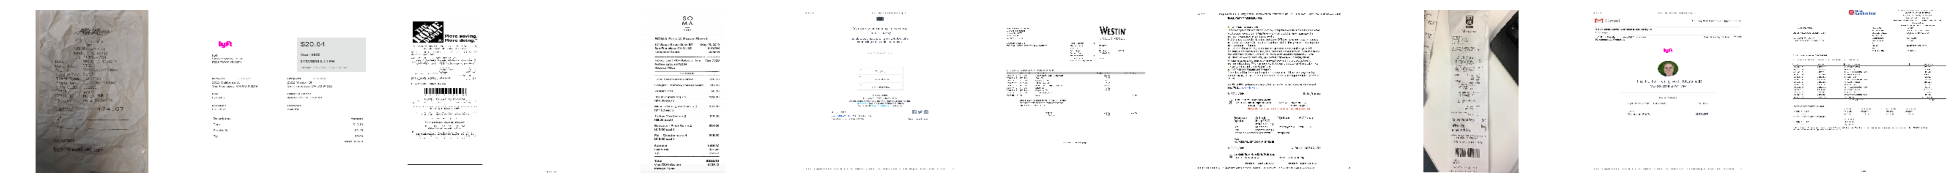

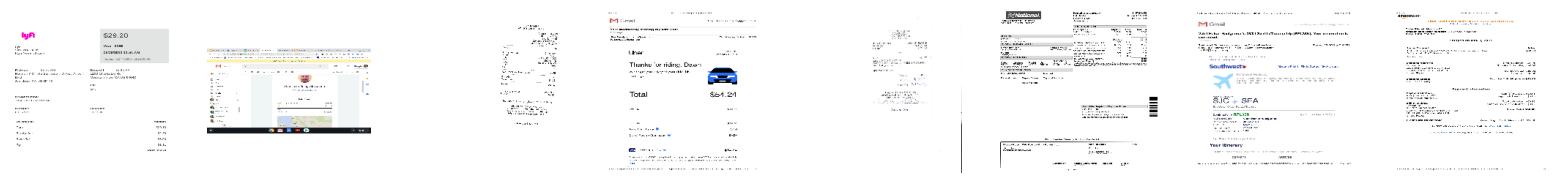

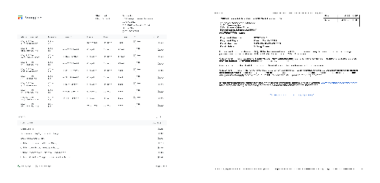

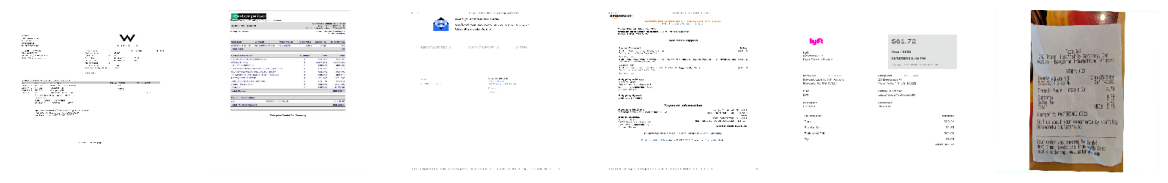

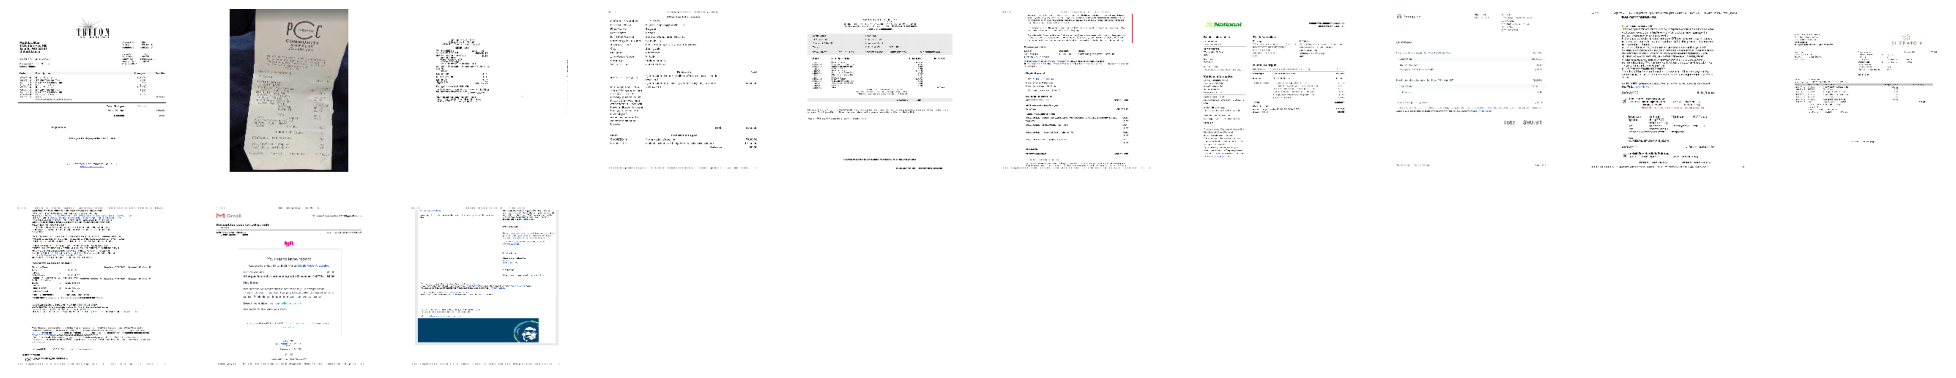

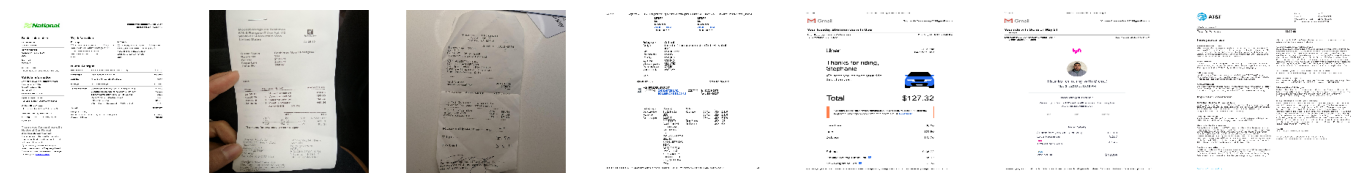

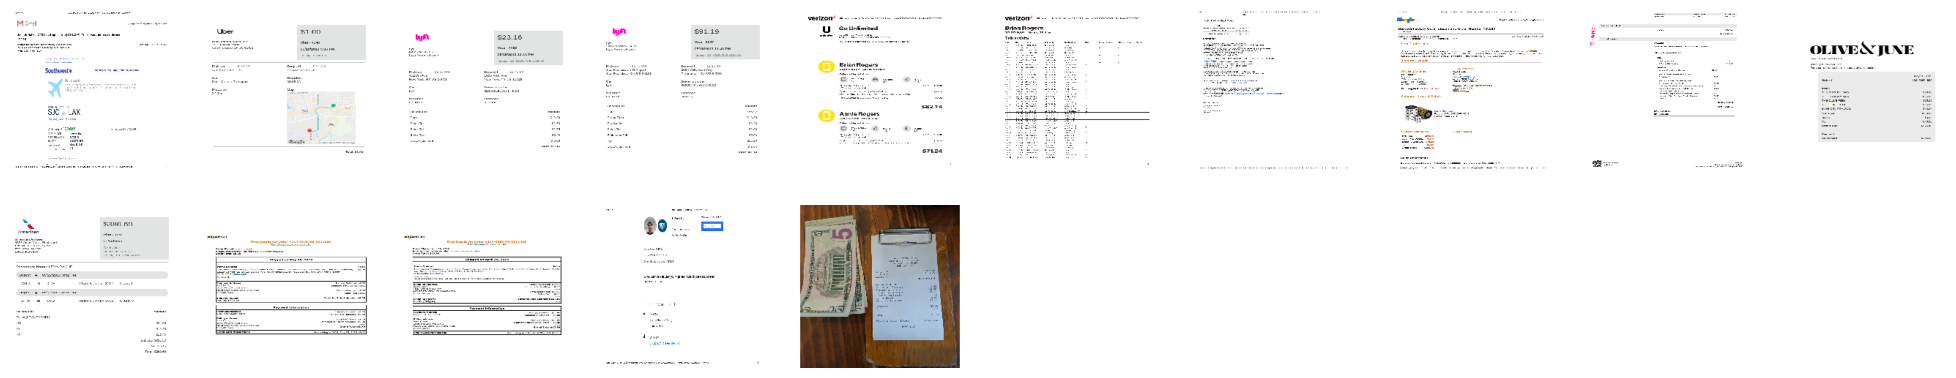

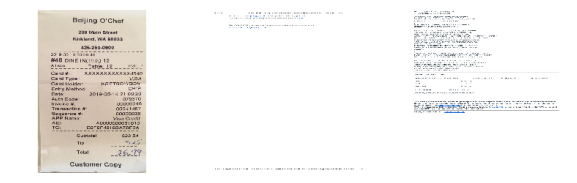

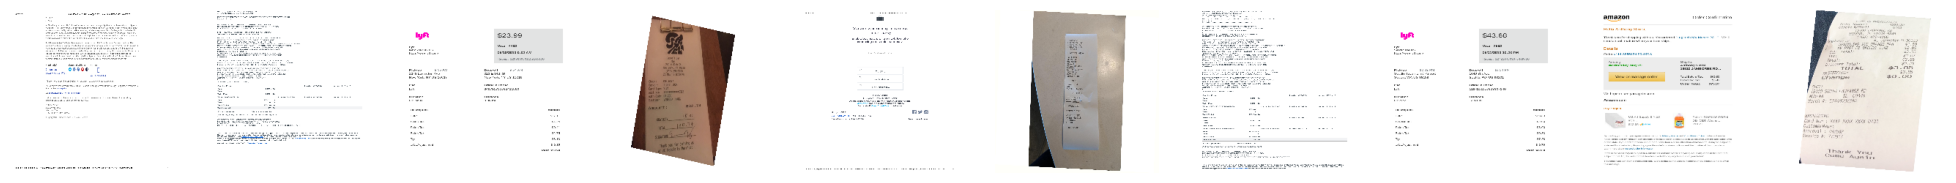

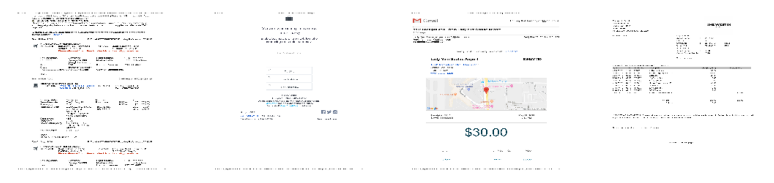

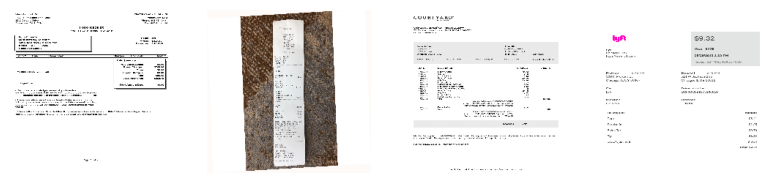

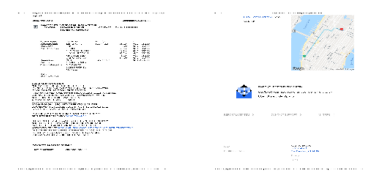

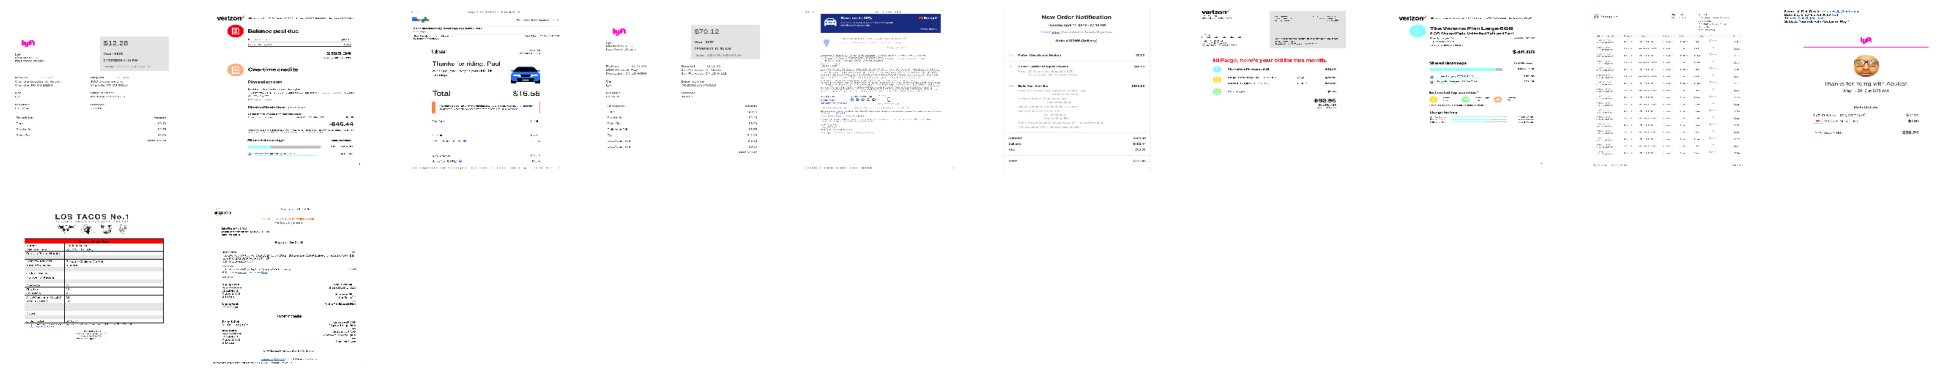

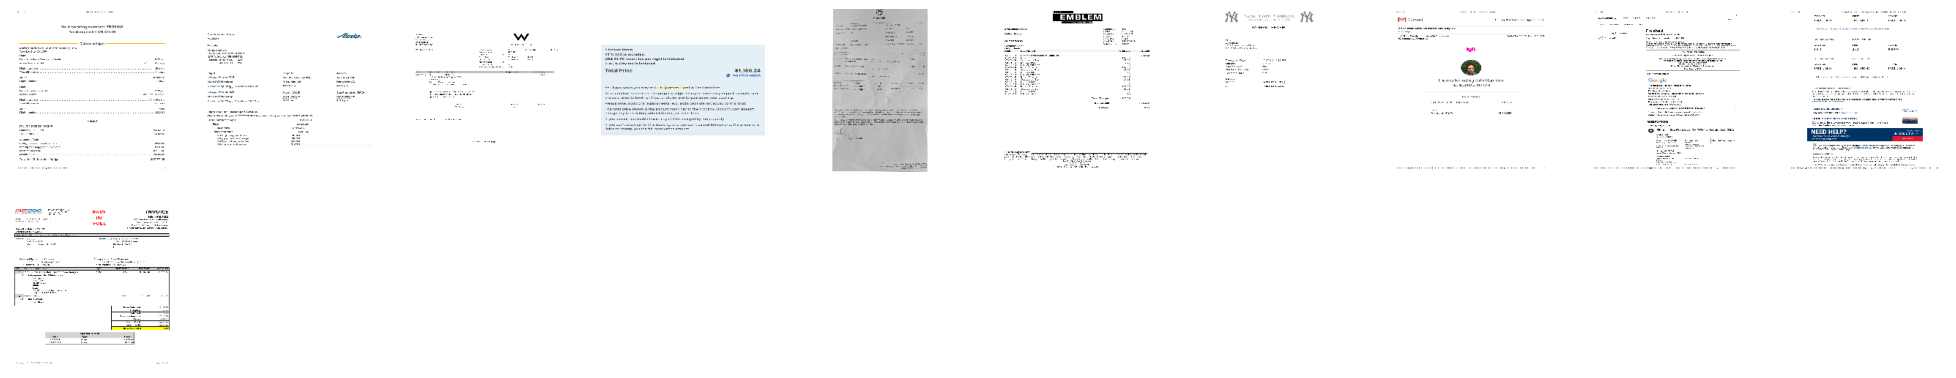

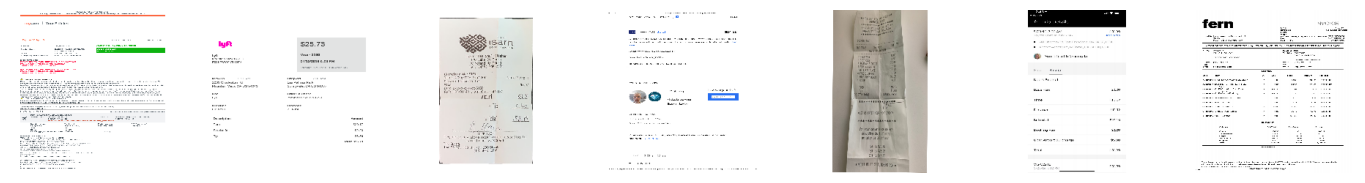

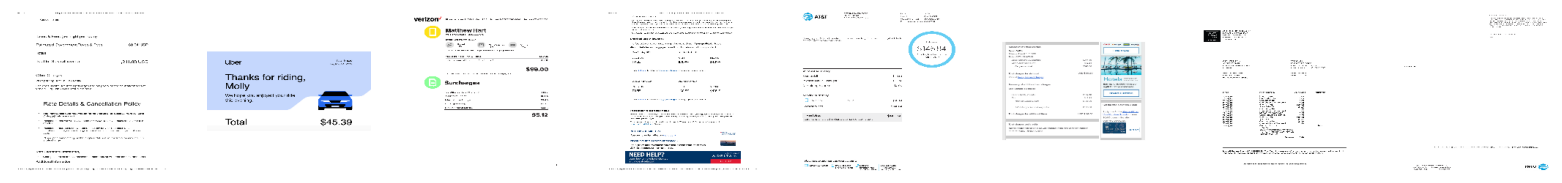

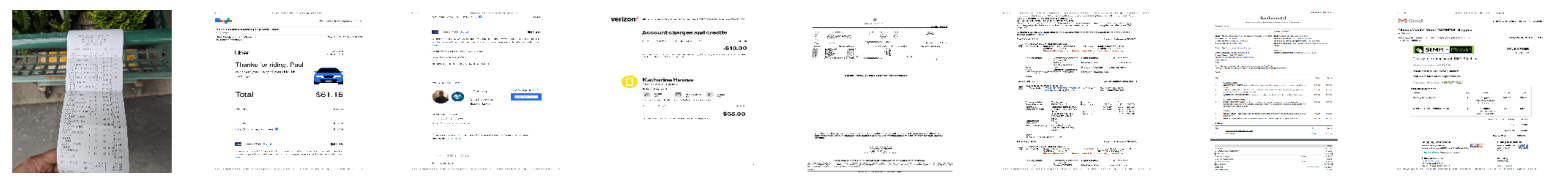

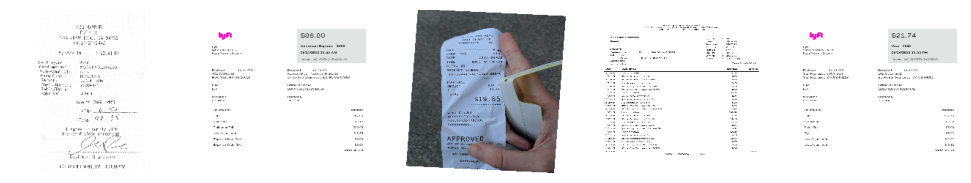

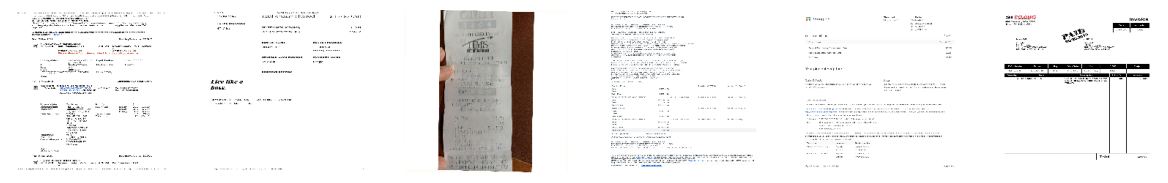

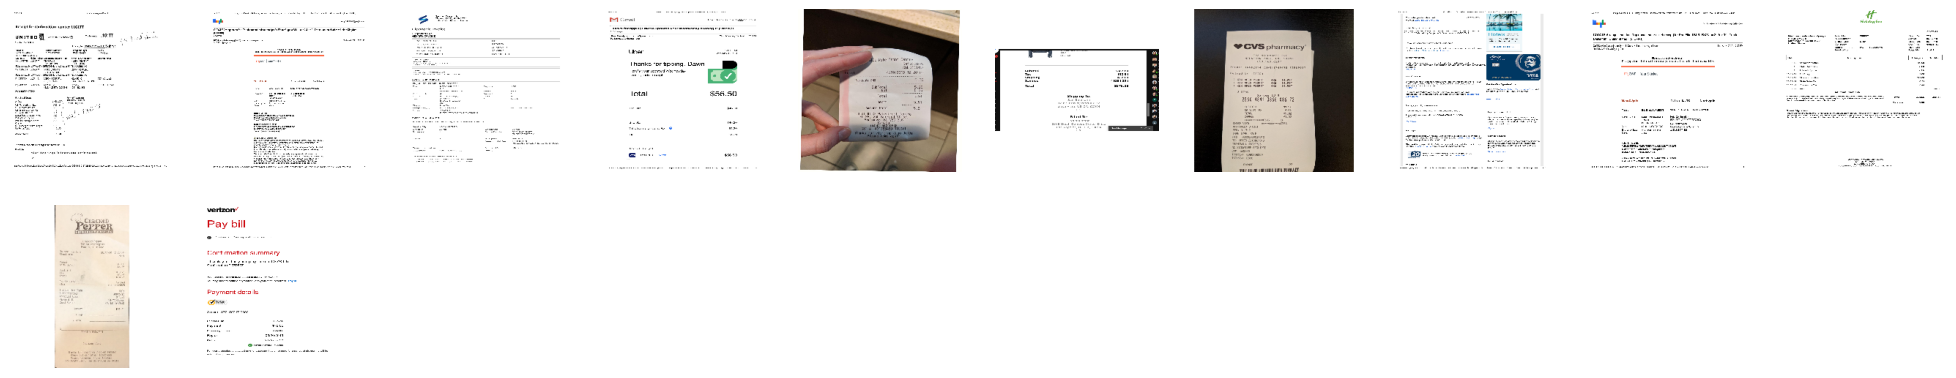

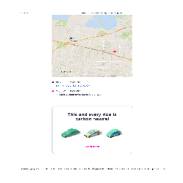

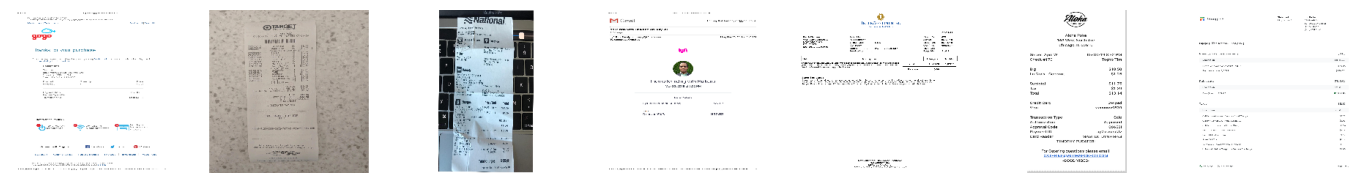

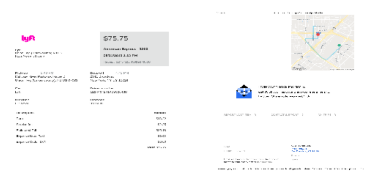

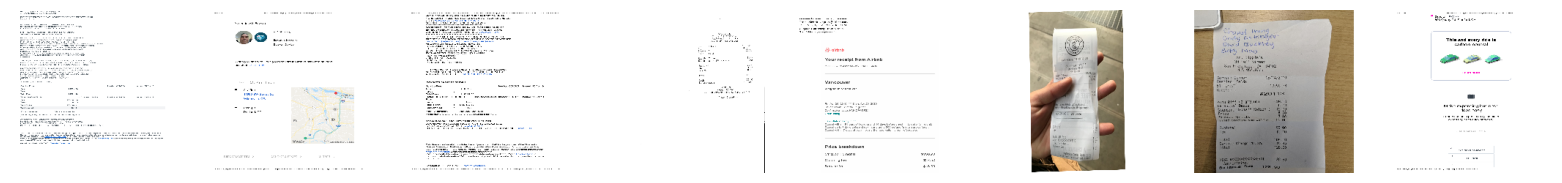

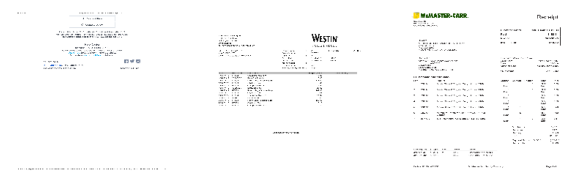

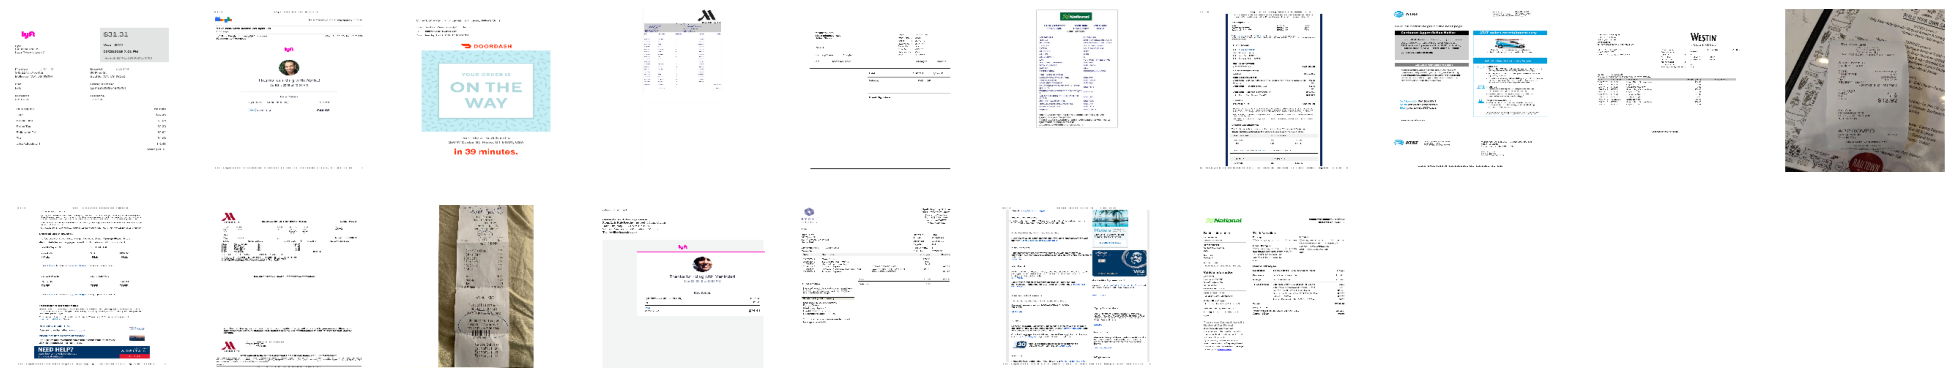

In [84]:
# save images of clusters as pdf to review cluster assignments
storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.get_bucket(BUCKET_NAME)

# The PDF document
pdf_pages = PdfPages('Expense/test_cluster_examples.pdf')

for i in range(len(groups)):
  pdf_pages.savefig(view_cluster(groups, i, 30))

# Write the PDF document to the disk
pdf_pages.close()

# Removing Bad clusters

In [63]:
#remove clusters 0,3,7,8,9,11,14
feat_refined = []
filenames_refined = []
labels = []
 
for features, filename, cluster in zip(feat, filenames, kmeans.labels_):
    if cluster not in  cluster_to_remove:
        feat_refined.append(features)
        filenames_refined.append(filename)
        labels.append(cluster)

print(f'{len(feat_refined)} samples remain for round 2 of clustering')

239 samples remain for round 2 of clustering


In [64]:
# PCA of remaining samples
feat_refined = np.array(feat_refined).reshape(-1,4096)
pca = PCA(n_components=30, random_state=22)
pca.fit(feat_refined)
x = pca.transform(feat_refined)

328238.375 1
261253.28125 2
224512.046875 3
200545.203125 4
185701.46875 5
173448.984375 6
162535.203125 7
154565.3125 8
147705.09375 9
141203.203125 10
137158.0625 11
132276.828125 12
128535.59375 13
124638.109375 14
120400.359375 15
116549.625 16
116368.4453125 17
112283.859375 18
110292.6875 19
108056.3125 20
103464.46875 21
102624.5390625 22
99695.59375 23
97106.7265625 24
97149.4921875 25
93490.7578125 26
92090.328125 27
90037.484375 28
87556.4609375 29
86021.40625 30
84498.296875 31
82746.640625 32
82289.6484375 33
80255.59375 34
78137.0703125 35
76115.6015625 36
76125.8125 37
75040.828125 38
72388.9296875 39
71550.296875 40
70628.375 41
69400.1171875 42
68751.1484375 43
66972.2578125 44
66036.53125 45
64050.38671875 46
62496.09375 47
62379.4921875 48
61442.23828125 49


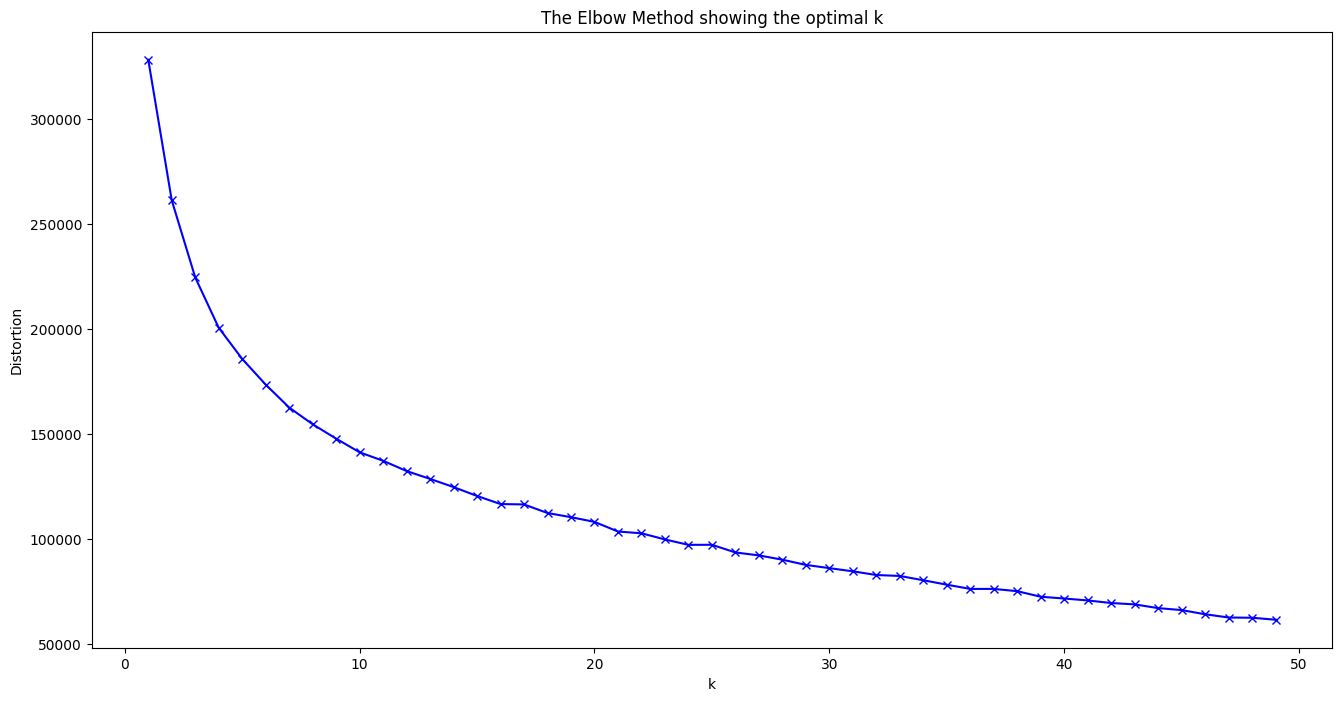

In [65]:
# Elbow plot
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(x)
    distortions.append(kmeanModel.inertia_)
    print(kmeanModel.inertia_,k)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for i in range(2,50):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(x)

    # Calculate the silhouette score
    labels = kmeans.labels_

    silhouette_avg = silhouette_score(x, kmeans.labels_)
    print(f"The average silhouette score for K={i} is :{silhouette_avg}" )
    

The average silhouette score for K=2 is :0.18722569942474365
The average silhouette score for K=3 is :0.1900864988565445
The average silhouette score for K=4 is :0.18608513474464417
The average silhouette score for K=5 is :0.1696523278951645
The average silhouette score for K=6 is :0.16452352702617645
The average silhouette score for K=7 is :0.17055919766426086
The average silhouette score for K=8 is :0.1721850335597992
The average silhouette score for K=9 is :0.17831750214099884
The average silhouette score for K=10 is :0.18403270840644836
The average silhouette score for K=11 is :0.18745659291744232
The average silhouette score for K=12 is :0.19363923370838165
The average silhouette score for K=13 is :0.18618088960647583
The average silhouette score for K=14 is :0.19134952127933502
The average silhouette score for K=15 is :0.18308895826339722
The average silhouette score for K=16 is :0.19460004568099976
The average silhouette score for K=17 is :0.17773562669754028
The average silhoue

In [67]:
# cluster feature vectors into 6 clusters with kmeans algorithm
kmeans = KMeans(n_clusters=13,random_state=22)
kmeans.fit(x)
df3 = pd.DataFrame(columns = ['FileName',"cluster"])
# print(df)
# generate dictionary that holds the cluster id and the file names { id: [file_name] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    # print(file,cluster)
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
        dict = {'FileName':file,"cluster":cluster}
        df3 = df3.append(dict,ignore_index=True)
    else:
        groups[cluster].append(file)
        dict = {'FileName':file,"cluster":cluster}
        df3 = df3.append(dict,ignore_index=True)
df3.to_csv('Expense/output_refined.csv')

In [68]:
df4 = df3.groupby("cluster").count()
df4
df4.rename(columns = {"FileName" : 'File_Count'},inplace = True)
df4.to_csv('Expense/eval_output_round2.csv')

In [29]:
cluster_to_remove = list(df4[df4['FileName'] < 5].index)
len(cluster_to_remove)

0

In [30]:
#Test
df_test = pd.read_csv('output.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'output.csv'

In [30]:
df_test1 = df_test.groupby('cluster').count()
df_test1.drop('Unnamed: 0',inplace= True,axis = 1)
df_test1

FileName
cluster          
0              53
1              79
2              35
3              63
4              41
5              44
6              50
7              18
8              27
9              55
10             29
11             23
12             32
13             56
14             69
15             42
16             61

In [34]:
pwd

'/home/jupyter/image Cluster Results'

In [35]:
cd

/home/jupyter
